In [1]:
from torch import cuda


device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
import kaggle
import os


kaggle.api.authenticate()
data_path = "./corpus/"
if not os.path.exists(data_path):
    os.makedirs(data_path)
    print(f"Directory created: {data_path}")
    
kaggle.api.dataset_download_files('marcelhiltner/pubmed-human-veterinary-medicine-classification', path=data_path, unzip=True)
print(os.listdir(data_path))

Directory created: ./corpus/
['test.json', 'train.json', 'valid.json']


In [11]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 325.1 kB/s eta 0:00:40
     ---------------------------------------- 0.1/12.8 MB 1.1 MB/s eta 0:00:12
     - -------------------------------------- 0.5/12.8 MB 2.7 MB/s eta 0:00:05
     --- ------------------------------------ 1.0/12.8 MB 4.5 MB/s eta 0:00:03
     ----- ---------------------------------- 1.8/12.8 MB 6.9 MB/s eta 0:00:02
     ------ --------------------------------- 2.0/12.8 MB 6.4 MB/s eta 0:00:02
     ------- -------------------------------- 2.5/12.8 MB 7.2 MB/s eta 0:00:02
     ---------- ----------------------------- 3.2/12.8 MB 7.9 MB/s eta 0:00:02
     ------------- -------------------------- 4.2/12.8 MB 9.9 MB/s eta 0:00:01
     --------------- ------------------------ 5.0/12.8 MB 10.4 MB/s eta 0:00:01
     ----------------- ---------------------- 5.4/12.8 MB 10.2 M

In [15]:
import pandas as pd
import re
import spacy

from Source_code.z_utils.lemmatize import lemmatize


try:
    lemmatizer = spacy.load('en_core_web_sm')
    
    train_set = pd.read_json(f"{data_path}train.json", orient="records")
    train_set["title_abstract"] = train_set["title_abstract"].apply(lambda x: re.sub(r'\d', '', x))
    train_set["title_abstract"] = train_set["title_abstract"].apply(lambda x: lemmatize(lemmatizer, x))
    print("Data loaded successfully: train.json")
    print(f"Shape: {train_set.shape}")
    
    val_set = pd.read_json(f"{data_path}valid.json", orient="records")
    val_set["title_abstract"] = val_set["title_abstract"].apply(lambda x: re.sub(r'\d', '', x))
    val_set["title_abstract"] = val_set["title_abstract"].apply(lambda x: lemmatize(lemmatizer, x))
    print("Data loaded successfully: valid.json")
    print(f"Shape: {val_set.shape}")
    
    test_set = pd.read_json(f"{data_path}test.json", orient="records")
    test_set["title_abstract"] = test_set["title_abstract"].apply(lambda x: re.sub(r'\d', '', x))
    print("Data loaded successfully: test.json")
    print(f"Shape: {test_set.shape}")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully: train.json
Shape: (20, 7)
Data loaded successfully: valid.json
Shape: (20, 7)
Data loaded successfully: test.json
Shape: (20, 7)


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

from Source_code.z_utils.global_constants import *


vectorizer = TfidfVectorizer(
                ngram_range=(1, 3),
                strip_accents="ascii",
                lowercase=True,
                max_features=38000,
                )

train_x = vectorizer.fit_transform(train_set["title_abstract"])
train_y = train_set["labels"]

if not os.path.exists(PATH_SAVED_MODELS):
    os.makedirs(PATH_SAVED_MODELS)
joblib.dump(vectorizer, f"{PATH_SAVED_MODELS}{vectorizer}.pkl")

val_x = vectorizer.transform(val_set["title_abstract"])
val_y = val_set["labels"]
test_x = vectorizer.transform(test_set["title_abstract"])
test_y = test_set["labels"]

In [19]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import joblib
import time
import datetime
import json

from Source_code.z_utils.global_constants import *

MODEL_CHECKPOINT = "svm"

time0 = time.monotonic_ns()

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

svm = LinearSVC(random_state=RANDOM_SEED, dual=False, max_iter=1000)

grid_search = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy', verbose=4, return_train_score=True)
result = grid_search.fit(train_x, train_y)
best_svm = result.best_estimator_

if not os.path.exists(PATH_SAVED_MODELS):
    os.makedirs(PATH_SAVED_MODELS)
joblib.dump(best_svm, f"{PATH_SAVED_MODELS}{MODEL_CHECKPOINT}.pkl")

elapsed_time = datetime.timedelta(microseconds=(time.monotonic_ns() - time0)/1000)

if not os.path.exists(PATH_SAVED_METRICS):
    os.makedirs(PATH_SAVED_METRICS)
with open(f"{PATH_SAVED_METRICS}run_times_{MODEL_CHECKPOINT}.json", "w") as outfile:
    json.dump({"total_time": str(elapsed_time), "refit_time": result.refit_time_}, outfile)
pd.DataFrame(result.cv_results_).to_json(f"{PATH_SAVED_METRICS}cv_results_{MODEL_CHECKPOINT}.json")
with open(f"{PATH_SAVED_METRICS}best_values_{MODEL_CHECKPOINT}.json", "w") as outfile:
    json.dump({"best_acc": result.best_score_, "best_params": result.best_params_}, outfile)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV 1/10] END ......C=0.001;, score=(train=0.556, test=0.500) total time=   0.0s
[CV 2/10] END ......C=0.001;, score=(train=0.556, test=0.500) total time=   0.0s
[CV 3/10] END ......C=0.001;, score=(train=0.556, test=0.500) total time=   0.0s
[CV 4/10] END ......C=0.001;, score=(train=0.556, test=0.500) total time=   0.0s
[CV 5/10] END ......C=0.001;, score=(train=0.556, test=0.500) total time=   0.0s
[CV 6/10] END ......C=0.001;, score=(train=0.556, test=0.500) total time=   0.0s
[CV 7/10] END ......C=0.001;, score=(train=0.556, test=0.500) total time=   0.0s
[CV 8/10] END ......C=0.001;, score=(train=0.556, test=0.500) total time=   0.0s
[CV 9/10] END ......C=0.001;, score=(train=0.556, test=0.500) total time=   0.0s
[CV 10/10] END .....C=0.001;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 1/10] END .......C=0.01;, score=(train=0.556, test=0.500) total time=   0.0s
[CV 2/10] END .......C=0.01;, score=(train=0.556

c:\Users\albbl\Documents\Studium\11_Semester\appendix_code\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


[CV 3/10] END ..........C=1;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 4/10] END ..........C=1;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 5/10] END ..........C=1;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 6/10] END ..........C=1;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 7/10] END ..........C=1;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 8/10] END ..........C=1;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 9/10] END ..........C=1;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 10/10] END .........C=1;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 1/10] END .........C=10;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 2/10] END .........C=10;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 3/10] END .........C=10;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 4/10] END .........C=10;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 5/10] END .........C=10;

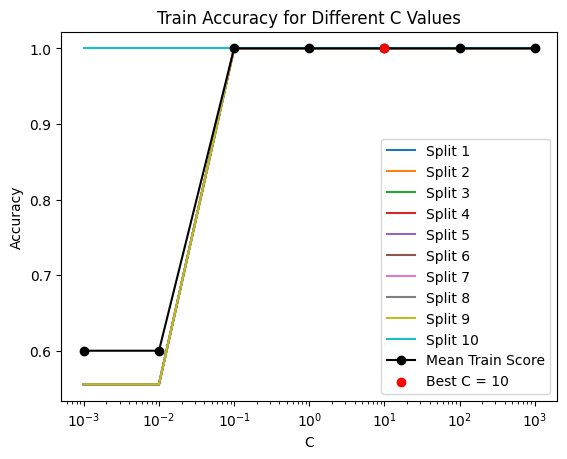

In [20]:
import matplotlib.pyplot as plt


param_C_values = [param['C'] for param in result.cv_results_["params"]]
split_train_scores = [result.cv_results_[f"split{i}_train_score"] for i in range(10)]

for i, split_train_score in enumerate(split_train_scores):
    plt.plot(param_C_values, split_train_score, label=f"Split {i + 1}")

mean_train_scores = result.cv_results_["mean_train_score"]
plt.plot(param_C_values, mean_train_scores, marker="o", linestyle="-", color="black", label="Mean Train Score")

best_c = result.best_params_["C"]
plt.scatter(best_c, mean_train_scores[result.best_index_], color="red", label=f"Best C = {best_c}", zorder=5)

plt.xlabel("C")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.legend()
plt.savefig(f"Train_Accuracy_for_Different_C_Values_{MODEL_CHECKPOINT}.pdf", format="pdf", bbox_inches="tight")
plt.title("Train Accuracy for Different C Values")
plt.show()
plt.close()

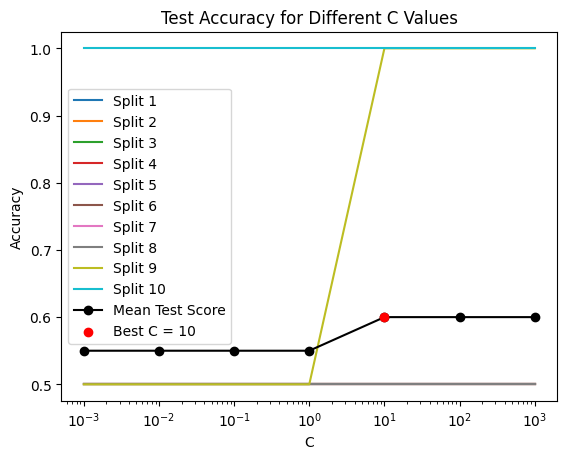

In [21]:
split_test_scores = [result.cv_results_[f"split{i}_test_score"] for i in range(10)]

for i, split_test_score in enumerate(split_test_scores):
    plt.plot(param_C_values, split_test_score, label=f"Split {i + 1}")

mean_test_scores = result.cv_results_["mean_test_score"]
plt.plot(param_C_values, mean_test_scores, marker="o", linestyle="-", color="black", label="Mean Test Score")

plt.scatter(best_c, mean_test_scores[result.best_index_], color="red", label=f"Best C = {best_c}", zorder=5)

plt.xlabel("C")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.legend()
plt.savefig(f"Validation_Accuracy_for_Different_C_Values_{MODEL_CHECKPOINT}.pdf", format="pdf", bbox_inches="tight")
plt.title("Test Accuracy for Different C Values")
plt.show()
plt.close()

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import pickle
import time
import datetime


time0 = time.monotonic_ns()

test_set["title_abstract"] = test_set["title_abstract"].apply(lambda x: lemmatize(lemmatizer, x))
test_x = vectorizer.transform(test_set["title_abstract"])
pred_y = best_svm.predict(test_x)

elapsed_time = datetime.timedelta(microseconds=(time.monotonic_ns() - time0)/1000)
print((time.monotonic_ns() - time0))
print(elapsed_time)

cm = confusion_matrix(test_y, pred_y)
print(cm)

cr = classification_report(test_y, pred_y)
print(cr) 

with open(f"{PATH_SAVED_METRICS}test_report_{MODEL_CHECKPOINT}", 'wb') as f:
    pickle.dump(cr, f)

1187000000
0:00:01.187000
[[10  1]
 [ 3  6]]
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.86      0.67      0.75         9

    accuracy                           0.80        20
   macro avg       0.81      0.79      0.79        20
weighted avg       0.81      0.80      0.80        20



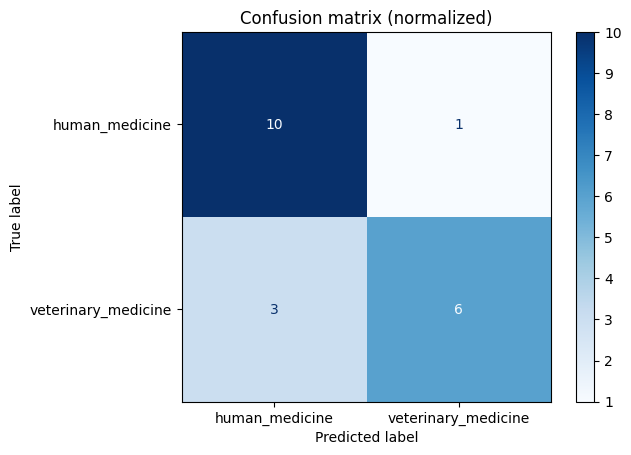

In [24]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


labels = list(LABELS_MAP.keys())
test_classes = [labels[0] if label == 0 else labels[1] for label in test_y]
preds_classes = [labels[0] if label == 0 else labels[1] for label in pred_y]
test_set.title_abstract[test_set.labels != pred_y].to_json(f"{PATH_SAVED_METRICS}test_false_predictions_svm.json")
disp = ConfusionMatrixDisplay.from_predictions(test_classes, preds_classes, labels=labels, normalize=None, cmap=plt.cm.Blues)
plt.savefig(f"Confusion_matrix_{MODEL_CHECKPOINT}.pdf", format="pdf", bbox_inches="tight")
disp.ax_.set_title("Confusion matrix (normalized)")
plt.show()
plt.close()